# Unit Reports

ToDs:
- add serial position surrogates plot.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
from scipy.stats import sem, ttest_rel

from convnwb.io import load_nwbfile

#from pingouin import convert_angles, circ_rayleigh

from spiketools.measures import compute_isis
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.plts.spikes import plot_isis
from spiketools.plts.spatial import plot_positions, plot_heatmap
from spiketools.plts.trials import plot_rasters
from spiketools.plts.data import plot_bar, plot_polar_hist, plot_text
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_grid, get_grid_subplot
from spiketools.plts.annotate import color_pval
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.spatial.occupancy import (compute_occupancy, compute_bin_edges,
                                          compute_bin_firing, compute_bin_assignment)
from spiketools.spatial.information import compute_spatial_information
from spiketools.utils.data import compute_range
from spiketools.utils.base import select_from_list
from spiketools.utils.trials import epoch_spikes_by_event, epoch_spikes_by_range, epoch_data_by_range

In [3]:
import sys
sys.path.append('../code')
from analysis import calc_trial_frs, get_spike_positions, get_spike_heading
from place import get_trial_place, compute_place_bins, create_df_place, fit_anova_place
from target import compute_spatial_target_bins, get_trial_target, create_df_target, fit_anova_target
from serial import compute_serial_position_fr, create_df_serial, fit_anova_serial
from reports import create_unit_info, create_unit_str

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/NWB')
#data_folder = Path('/scratch/tom.donoghue/TH/')

In [6]:
# Define subject information
session = {
    'task' : 'THO',
    'subject' : 'wv001',
    'session' : 2    
}

In [7]:
# Set which example unit to extract
uind = 84

In [8]:
# Define bins to use
bins = [9, 12]
chest_bins = [5, 7]

# Define minimum occupancy
min_occ = 1

# Set the time range to analyze
trial_range = [-1, 1]

In [9]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 25

In [10]:
# Set which methods to run
PLACE_METHOD = 'ANOVA'
TARGET_METHOD = 'ANOVA'

## Load Data

In [11]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

In [12]:
# Get the subject & session ID from file
subj_id = nwbfile.subject.subject_id
session_id = nwbfile.session_id

#### Trial Data

In [13]:
# Get start and stop time of trials
trial_starts = nwbfile.trials['start_time'].data[:]
trial_stops = nwbfile.trials['stop_time'].data[:]

In [14]:
# Get trial indices of interest
chest_trials = nwbfile.trials.chest_trials[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

In [15]:
# Get masks for full and empty chest trials
full_mask = nwbfile.trials.full_chest.data[:]
empty_mask = np.invert(full_mask)

In [16]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Position data

In [17]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:], 
              nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-15, 15])]

In [18]:
# Get the position data & speed data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [19]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

In [20]:
# # Extract head position data
# hd_times = nwbfile.acquisition['heading']['direction'].timestamps[:]
# hd_degrees = nwbfile.acquisition['heading']['direction'].data[:]

In [21]:
# Get the chest positions
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T

In [22]:
# Fix for extra chest position
if len(chest_xs) > len(chest_trials):
    chest_xs = chest_xs[:len(chest_trials)]
    chest_ys = chest_ys[:len(chest_trials)]

#### Get Spikes

In [23]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

### Precompute Some Things

In [24]:
# Get the spiking data for each trial
all_trials = epoch_spikes_by_range(spikes, trial_starts, trial_stops, reset=True)

In [25]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [26]:
# Epoch around chest openings
all_chests = epoch_spikes_by_event(spikes, np.concatenate(chest_openings), trial_range)
empty_trials = select_from_list(all_chests, empty_mask)
full_trials = select_from_list(all_chests, full_mask)

In [27]:
# Compute firing rate around chest events
fr_pre_all, fr_post_all = calc_trial_frs(all_chests)
fr_pre_empt, fr_post_empt = calc_trial_frs(empty_trials)
fr_pre_full, fr_post_full = calc_trial_frs(full_trials)

In [28]:
# Compute bin edges
x_bin_edges, y_bin_edges = compute_bin_edges(positions, bins, area_range=area_range)

In [29]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
spike_positions = np.array([spike_xs, spike_ys])

In [30]:
# Compute occupancy
occ_kwargs = {'minimum' : min_occ, 'area_range' : area_range, 'set_nan' : True}
occ = compute_occupancy(positions, ptimes, bins, speed, **occ_kwargs)

In [31]:
# Compute spatial bin assignments & binned firing, and normalize by occupancy
x_binl, y_binl = compute_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)
bin_firing = compute_bin_firing(bins, x_binl, y_binl)
bin_firing = bin_firing / occ

In [32]:
# # Get head direction for each spike
# spike_hds = get_spike_heading(spikes, hd_times, hd_degrees)

In [33]:
# Compute edges for chest binning
ch_x_edges, ch_y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range)

# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, ch_x_edges, ch_y_edges)

# Fix offset of chest binning
ch_xbin = ch_xbin - 1
ch_ybin = ch_ybin - 1

# Compute chest occupancy
chest_occupancy = compute_bin_firing(chest_bins, ch_xbin, ch_ybin)

### Statistical Measures

In [34]:
# Compute t-test for chest related firing
fr_t_val_all, fr_p_val_all = ttest_rel(*calc_trial_frs(all_chests, average=False))
fr_t_val_full, fr_p_val_full = ttest_rel(*calc_trial_frs(full_trials, average=False))
fr_t_val_empt, fr_p_val_empt = ttest_rel(*calc_trial_frs(empty_trials, average=False))

In [35]:
# Place cell analysis
if PLACE_METHOD == 'INFO':
    place_value = compute_spatial_information(bin_firing, occ)
if PLACE_METHOD == 'ANOVA':
    place_trial = get_trial_place(spikes, nwbfile.trials, bins, ptimes, positions,
                                  speed, x_bin_edges, y_bin_edges, occ_kwargs)
    place_value = fit_anova_place(create_df_place(place_trial, drop_na=True))

In [36]:
# Target cell analysis
target_bins = compute_spatial_target_bins(spikes, nav_starts, chest_openings, chest_trials, 
                                          ptimes, positions, chest_bins, ch_xbin, ch_ybin)
target_bins = target_bins.T # TEMP FIX
if TARGET_METHOD == 'INFO':
    target_value = compute_spatial_information(target_bins, chest_occupancy)
if TARGET_METHOD == 'ANOVA':
    target_trial = get_trial_target(spikes, nav_starts, chest_bins, chest_openings,
                                    chest_trials, ch_xbin, ch_ybin, ptimes, positions)
    target_value = fit_anova_target(create_df_target(target_trial))

In [37]:
# Serial position analysis
sp_all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings, chest_trials)
sp_value = fit_anova_serial(create_df_serial(sp_all_frs))

In [38]:
# Head direction analysis
# # Compute measures for head direction
# hd_zstat, hd_pstat = circ_rayleigh(convert_angles(spike_hds))

### Surrogates

In [39]:
# Define which analyses to run surrogates on
surr_analyses = ['place_info',
                 'place_anova',
                 'target_info',
                 'target_anova',
                 'sp_anova']

# Initialize surrogate output array
surrs = {analysis : np.zeros(n_surrogates) for analysis in surr_analyses}

In [40]:
# Compute surrogate measures
for ind, shuffle in enumerate(times_shuffle):    
    
    # PLACE
    if PLACE_METHOD == 'INFO':
        surr_bin_firing = compute_place_bins(stimes, bins, ptimes, positions, x_bin_edges, y_bin_edges)
        surrs['place_info'][ind] = compute_spatial_information(bin_firing, occ, normalize=True)
    if PLACE_METHOD == 'ANOVA':
        s_place_trial = get_trial_place(shuffle, nwbfile.trials, bins, ptimes, positions,
                                      speed, x_bin_edges, y_bin_edges, occ_kwargs)
        surrs['place_anova'][ind] = fit_anova_place(create_df_place(s_place_trial, drop_na=True))
    
    # TARGET
    if TARGET_METHOD == 'INFO':
        s_target_bins = compute_spatial_target_bins(shuffle, nav_starts,
                                                    chest_openings, chest_trials, 
                                                    ptimes, positions,
                                                    chest_bins, ch_xbin, ch_ybin)     
        s_target_bins = s_target_bins.T # TEMP FIX
        surrs['target_info'][ind] = compute_spatial_information(s_target_bins, chest_occupancy)
    if TARGET_METHOD == 'ANOVA':
        s_target_trial = get_trial_target(shuffle, nav_starts, chest_bins, chest_openings,
                                        chest_trials, ch_xbin, ch_ybin, ptimes, positions)
        surrs['target_anova'][ind] = fit_anova_target(create_df_target(s_target_trial))
    
    # SERIAL POSITION
    s_sp_all_frs = compute_serial_position_fr(shuffle, nav_starts, chest_openings, chest_trials)
    surrs['sp_anova'][ind] = fit_anova_serial(create_df_serial(s_sp_all_frs))

#     # HEAD DIRECTION
#     s_spike_hds = get_spike_heading(shuffle, hd_times, hd_degrees)
#     surrs['hd_stat'][ind] = circ_rayleigh(convert_angles(s_spike_hds))[0]

In [41]:
# Compute surrogate statistics
place_p_val, place_z_score = compute_surrogate_stats(place_value, surrs['place_' + PLACE_METHOD.lower()])
target_p_val, target_z_score = compute_surrogate_stats(target_value, surrs['target_' + TARGET_METHOD.lower()])
sp_p_val, sp_z_score = compute_surrogate_stats(sp_value, surrs['sp_anova'])
# hd_p_val, hd_z_score = compute_surrogate_stats(hd_zstat, surrs['hd_stat'])

## Create Report

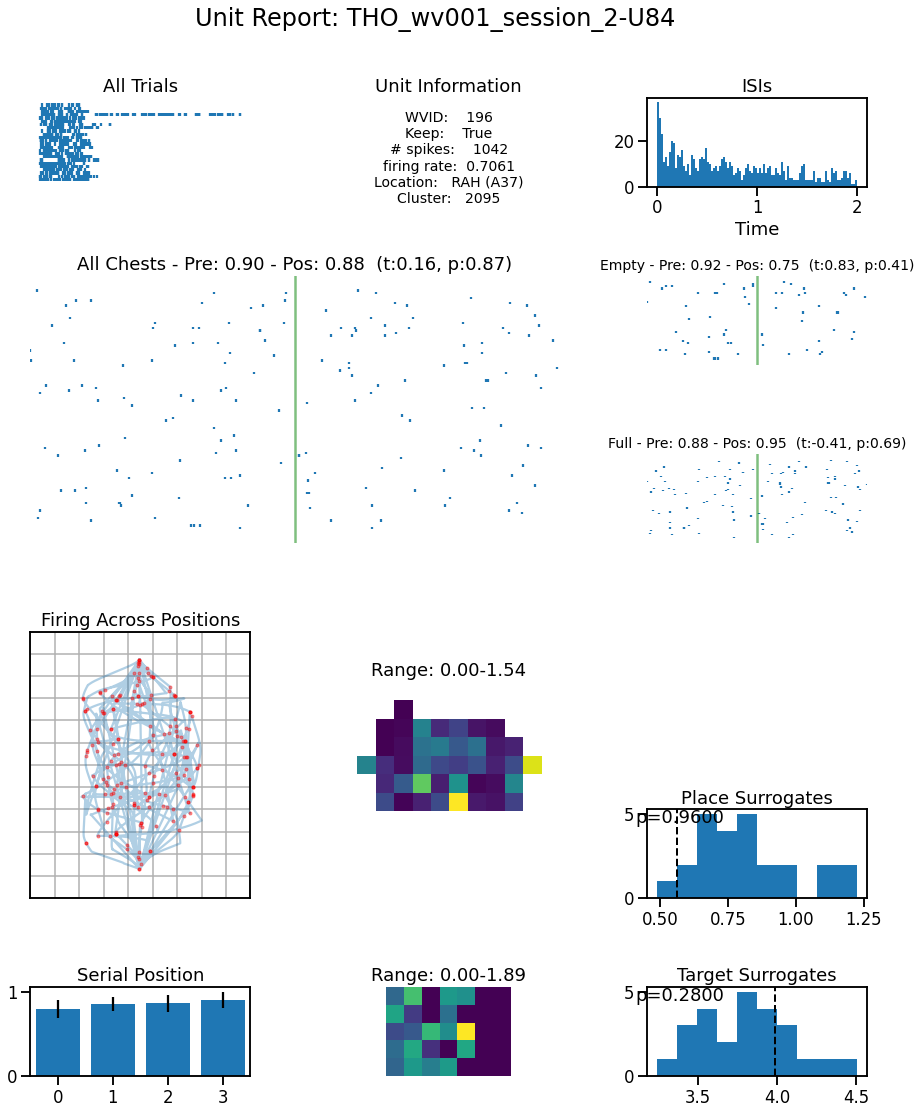

In [42]:
# Initialize figure with grid layout
grid = make_grid(6, 3, figsize=(15, 18), wspace=0.4, hspace=1.,
                 title='Unit Report: {}-U{}'.format(session_id, uind))

# 00: plot rasters across all trials
plot_rasters(all_trials, title='All Trials', ax=get_grid_subplot(grid, 0, 0))

# 01: unit information
plot_text(create_unit_str(create_unit_info(nwbfile.units[uind])),
          title='Unit Information', ax=get_grid_subplot(grid, 0, 1))

# 02: inter-spike intervals
plot_isis(compute_isis(spikes), bins=100, range=(0, 2), ax=get_grid_subplot(grid, 0, 2))

# 10: chest related firing
title_str = '{} - Pre: {:1.2f} - Pos: {:1.2f}  (t:{:1.2f}, p:{:1.2f})'
plot_rasters(all_chests, xlim=trial_range, vline=0, 
             title=title_str.format('All Chests', fr_pre_all, fr_post_all, fr_t_val_all, fr_p_val_all),
             title_color=color_pval(fr_p_val_all),
             ax=get_grid_subplot(grid, slice(1, 3), slice(0, 2)))

# 12&22: Compare Empty & Full chest trials
# Empty chest trials
plot_rasters(empty_trials, xlim=trial_range, vline=0,
             title=title_str.format('Empty', fr_pre_empt, fr_post_empt, fr_t_val_empt, fr_p_val_empt),
             title_color=color_pval(fr_p_val_empt), title_fontsize=14,
             ax=get_grid_subplot(grid, 1, 2))

# Full chest trials
plot_rasters(full_trials, xlim=trial_range, vline=0, 
             title=title_str.format('Full', fr_pre_full, fr_post_full, fr_t_val_full, fr_p_val_full),
             title_color=color_pval(fr_p_val_full), title_fontsize=14,
             ax=get_grid_subplot(grid, 2, 2))


# ax30: positional firing
plot_positions(positions, spike_positions, x_bins=x_bin_edges, y_bins=y_bin_edges,
               title='Firing Across Positions', 
               ax=get_grid_subplot(grid, slice(3, 5), 0))

# ax31: positional heatmap
plot_heatmap(bin_firing, transpose=True, ax=get_grid_subplot(grid, slice(3, 5), 1), 
             title='Range: {:1.2f}-{:1.2f}'.format(*compute_range(bin_firing)))

# ax32: head direction of spike firing
# plot_polar_hist(spike_hds, xticklabels=[], yticklabels=[],
#                 title='Head Direction', title_color=color_pval(hd_p_val),
#                 ax=get_grid_subplot(grid, 3, 2, polar=True))

# ax42: place surrogates
plot_surrogates(surrs['place_' + PLACE_METHOD.lower()], place_value, place_p_val,
                title='Place Surrogates', title_color=color_pval(place_p_val),
                ax=get_grid_subplot(grid, 4, 2))

# ax50: serial position
plot_bar(sp_all_frs.mean(0), [0, 1, 2, 3], yerr=sem(sp_all_frs, 0),
         title='Serial Position', title_color=color_pval(sp_p_val),
         ax=get_grid_subplot(grid, 5, 0))

# ax51: spatial target firing
plot_heatmap(target_bins, transpose=True, 
             title='Range: {:1.2f}-{:1.2f}'.format(*compute_range(target_bins)), 
             ax=get_grid_subplot(grid, 5, 1))

# ax52: target surrogates
plot_surrogates(surrs['target_' + TARGET_METHOD.lower()], target_value, target_p_val,
                title='Target Surrogates', title_color=color_pval(target_p_val),
                ax=get_grid_subplot(grid, 5, 2))